# Relax Take-Home Challenge

### Data
The data is available as two attached CSV files:

takehome_user_engagement.csv

takehome_users.csv

The data has the following two tables:

1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
    - name: the user's name
    - object_id: the user's id
    - email: email address
    - creation_source: how their account was created. This takes on one of 5 values:
        - PERSONAL_PROJECTS: invited to join another user's personal workspace
        - GUEST_INVITE: invited to an organization as a guest (limited permissions)
        - ORG_INVITE: invited to an organization (as a full member)
        - SIGNUP: signed up via the website
        - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (a Google email account for their login id)
    - creation_time: when they created their account
    - last_session_creation_time: unix timestamp of last login
    - opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    - enabled_for_marketing_drip: whether they are on the regular marketing email drip
    - org_id: the organization (group of users) they belong to
    - invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

### Objective
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.



In [357]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
engage = pd.read_csv('data/takehome_user_engagement.csv')
users = pd.read_csv('data/takehome_users.csv', encoding='latin-1')

### Data Cleaning

I will begin by performing some quick data cleaning on the datasets included. This will help us get them into a helfpul format for analysis down the road.

In [358]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [359]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [360]:
#Convert 'time_stamp' to datetime
engage.time_stamp = pd.to_datetime(engage.time_stamp, format='%Y-%m-%d %H:%M:%S')

In [361]:
engage.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

Luckily, the engage dataset is fairly clean. The only thing we need to do is convert the 'time_stamp' column to a datetime object. There are no null values in the dataset to take care of. Next, we will explore the users dataset for any cleaning we may need to do.

In [362]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [363]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


A few issues here. Namely, we need to convert the values of certain columns to the appropriate type. We also need to decide how to deal with the null values that are present here.

In [364]:
#Convert time columns to datetime objects
users.creation_time = pd.to_datetime(users.creation_time, format='%Y-%m-%d %H:%M:%S')
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

#Convert 'creation_source' to category object
users.creation_source = users.creation_source.astype('category')

#Convert 'opted_in_to_mailing_list' and 'enabled_for_marketing_drip' to booleans
users.opted_in_to_mailing_list = users.opted_in_to_mailing_list.astype('bool')
users.enabled_for_marketing_drip = users.enabled_for_marketing_drip.astype('bool')

In [365]:
#We will make the null values of 'invited_by_user_id' 0 because there are no instances
#in which a user's ID is 0
users.loc[users.invited_by_user_id.isnull(), 'invited_by_user_id'] = 0

Now that the data is pretty much cleaned up, we need to filter and find the 'adopted users' that are present. An adopted user is a user who has logged into the platform at 3 different times in at least one 7-day period. 

In [366]:
#Get the login counts for each user id
login_counts = engage.user_id.value_counts()

#Filter to identify those who have logged in at least 3 times
engage_3_or_more = engage[engage.user_id.isin(login_counts[login_counts > 2].index)]

#Make sure everything looks correct
engage_3_or_more.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


I will now take the objects created above to figure out which users were adopted. Below, I will identify which of those users who have logged in at 3 times did so within one 7-day stretch.

In [367]:
#Create empty list
adopted_users = []

#Iterate over users who have engaged 3 times or more
for user in engage_3_or_more.user_id.unique():
    
    #Identify each specific user's engagement
    user_engagement = engage_3_or_more[engage_3_or_more.user_id == user]
    
    #Get the timestamp for each
    user_timestamp = user_engagement.time_stamp.reset_index()["time_stamp"]
    
    #Iterate over each timestamp
    for i in range(len(user_timestamp) - 2):
        
        #Identify time interval
        time_interval = user_timestamp[i + 2] - user_timestamp[i]
        
        #Finally, make sure that interval is within a 7-day window
        if time_interval < pd.Timedelta("7 days"):
            
            #Append to empty list
            adopted_users.append(user)
            break

#How many adopted users to we have?
len(adopted_users)

1602

Out of 12,000 users in the dataset, we can only identify 1,602 who are 'adopted users'. What we need to do from here is to use the 'adopted_users' list we created above and create a new column. This new column will be called 'adopted' and it will return True if a user is an adopted user and False if they are not.

In [369]:
#Create new column for identifying whether a user is an adopted user or not
users['adopted'] = users.object_id.isin(adopted_users)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240.0,False


If we were to attempt to perform our analysis with a Random Forest model right now, it would have difficulty reading the dateime objects for 'creation_time' and 'last_session_creation_time' as they are right now. Therefore, we need to break them down into specific columns for the year, month and day. This is a more helpful way for our model to interpret the data.

In [370]:
#Break down datetime columns
users['creation_year'] = users.creation_time.dt.year
users['creation_month'] = users.creation_time.dt.month
users['creation_day'] = users.creation_time.dt.day

users['last_session_year'] = users.last_session_creation_time.dt.year
users['last_session_month'] = users.last_session_creation_time.dt.month
users['last_session_day'] = users.last_session_creation_time.dt.day

In [371]:
#No need for 'creation_time' and 'last_session_creation_time' anymore
users.drop(['creation_time', 'last_session_creation_time'], axis=1, inplace=True)

Another challenge we would run into if we were to jump right into our Random Forest model would be the 'creation_source' column. Right now, it contains 1 of 5 different sources. What I would like to do instead, is to one-hot encode those sources into their own column. That way, our model will be able to interpret the data more easily.

In [372]:
#Get one hot encoding of 'creation_source' column
one_hot = pd.get_dummies(users.creation_source)

#Drop 'creation_source as it is now encoded
users = users.drop('creation_source',axis = 1)

#Join the encoded df
users = users.join(one_hot)
users.head()

,object_id,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,Clausen August,AugustCClausen@yahoo.com,True,False,11,10803.0,False,2014,4,22,2014.0,4.0,22.0,1,0,0,0,0
1,2,Poole Matthew,MatthewPoole@gustr.com,False,False,1,316.0,True,2013,11,15,2014.0,3.0,31.0,0,1,0,0,0
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,False,False,94,1525.0,False,2013,3,19,2013.0,3.0,19.0,0,1,0,0,0
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,False,False,1,5151.0,False,2013,5,21,2013.0,5.0,22.0,1,0,0,0,0
4,5,Raw Grace,GraceRaw@yahoo.com,False,False,193,5240.0,False,2013,1,17,2013.0,1.0,22.0,1,0,0,0,0


In [373]:
#Double check for any null values
users.isnull().sum()

object_id                        0
name                             0
email                            0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
adopted                          0
creation_year                    0
creation_month                   0
creation_day                     0
last_session_year             3177
last_session_month            3177
last_session_day              3177
GUEST_INVITE                     0
ORG_INVITE                       0
PERSONAL_PROJECTS                0
SIGNUP                           0
SIGNUP_GOOGLE_AUTH               0
dtype: int64

In [374]:
#Fill those null values with 0
users.last_session_year.fillna(0, inplace=True)
users.last_session_month.fillna(0, inplace=True)
users.last_session_day.fillna(0, inplace=True)

We have now gotten the data to a point where can begin our analysis. I've decided to go with the Random Forest model because I am trying to predict whether a user will be adopted or not. The main objective for this project though is to see which features are most important when taking the prediction into consideration, so I will plot the results below.

### Random Forest

In [375]:
#Identify target variable
label = users.adopted

#Get features
#I will be dropping some columns that we do not need
features = users.drop(['name', 'email', 'object_id', 'adopted', 'invited_by_user_id'], axis=1)

In [376]:
#Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, 
                                                    test_size = 0.25, random_state = 7)

In [377]:
#Import Random Forest
from sklearn.ensemble import RandomForestClassifier

#Create a Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [378]:
#Which features are the most important?
feature_imp = pd.Series(clf.feature_importances_,index=features.columns).sort_values(ascending=False)
feature_imp

last_session_year             0.248115
last_session_month            0.197608
creation_month                0.159826
creation_year                 0.120375
last_session_day              0.111249
creation_day                  0.068318
org_id                        0.059011
opted_in_to_mailing_list      0.006917
enabled_for_marketing_drip    0.005409
ORG_INVITE                    0.005136
GUEST_INVITE                  0.005127
SIGNUP_GOOGLE_AUTH            0.004850
SIGNUP                        0.004064
PERSONAL_PROJECTS             0.003996
dtype: float64

Here we can see which features are most important. To make the information easier to decipher, I will plot a quick bar plot.

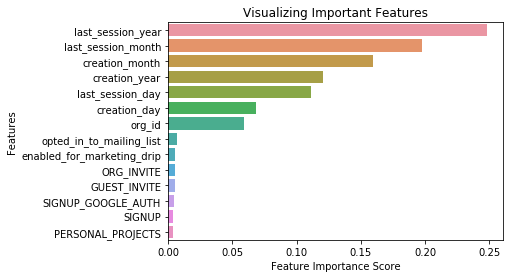

In [379]:
#Create a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

#Add graph labels
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Conclusion

It is clear from the plot above that the most important features are:

1. last_session_year
2. last_session_month
3. creation_month
4. creation_year
5. last_session_day
6. creation_day
7. org_id

Unsurprisingly, the last session seems to be a huge indicator of whether or not a user will end up becoming an adopted user or not. Interestingly, creation date seems to play a part as well, but not nearly as much as the last session. The 'org_id' feature is a fairly big indicator as well. This value tells us which organization this user is apart of. 

What I would recommend to the Relax stakeholders is invest in targeted advertising that will convince users to log in. You could even offer incentives or special rewards for users that log in more often. Any way that they could build user engagement and brand loyaltly will be huge for their customers.